In [21]:
from importlib.resources import files
import warnings
from itertools import zip_longest

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib.offsetbox import AnchoredText
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, roc_curve, balanced_accuracy_score, auc
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm

warnings.filterwarnings('ignore')
sns.set(style="darkgrid")

DATA_DIR = files("biobank_olink.data")
SEED = 42

In [22]:
cov_df = pd.read_csv(DATA_DIR / "BP_cov.zip", sep="\t", index_col="eid")
cat_cols = ["Sex", "Smokinstatus", "HTNgroup"]
reg_cols = list(cov_df.columns.difference(cat_cols))
print(f"Original cov shape: {cov_df.shape}")

ol_df = pd.read_csv(DATA_DIR / "olink_data_ins0.csv", index_col=0)
print(f"Original ol shape: {ol_df.shape}")

eids = cov_df.index.intersection(ol_df.index)[:1000]
cov_df = cov_df.loc[eids]
print(f"New cov shape: {cov_df.shape}")

ol_df = ol_df.loc[cov_df.index]
ol_df = pd.DataFrame(SimpleImputer(strategy="median").fit_transform(ol_df), index=ol_df.index, columns=ol_df.columns)
ol_df = pd.DataFrame(StandardScaler().fit_transform(ol_df), index=ol_df.index, columns=ol_df.columns)
print(f"New ol shape: {ol_df.shape}")

Original cov shape: (409519, 10)
Original ol shape: (52704, 1463)
New cov shape: (1000, 10)
New ol shape: (1000, 1463)


In [23]:
cov_df[cov_df == " "] = np.nan
cov_df[cov_df.HTNgroup == 4] = np.nan

In [24]:
replace_comma_with_dot_if_str = lambda x: x.replace(",", ".") if isinstance(x, str) else x
cols = ["BMI", "SBP", "DBP", "PP"]
cov_df[cols] = cov_df[cols].applymap(replace_comma_with_dot_if_str)
cov_df = cov_df.astype(float)

In [25]:
from sklearn.linear_model import LinearRegression


def run_regression_exp(ol, cl, exp_type: str, n_jobs=2):
    reg_results = []

    # model = ElasticNet(l1_ratio=0.3, max_iter=50_000, random_state=SEED)
    model = LinearRegression()
    reduced_x = PCA(n_components=0.95).fit_transform(ol)
    print(f"Reduced the number of features from {ol.shape[1]} to {reduced_x.shape[1]}")

    for col in tqdm(cl.columns, desc=f"Exp_type: {exp_type}"):
        y_true = cl[col].values
        
        y_nan_mask = ~np.isnan(y_true)
        y_true = y_true[y_nan_mask]
        x = reduced_x[y_nan_mask]
        y_pred = cross_val_predict(model, X=x, y=y_true, cv=5, n_jobs=n_jobs)

        corr, pval = pearsonr(y_true, y_pred)

        reg_results.append({
            "exp_type": exp_type,
            "col": col,
            "rmse": mean_squared_error(y_true, y_pred, squared=False),
            "r2": r2_score(y_true, y_pred),
            "corr": corr,
            "pval": pval,
            "y_pred": y_pred,
            "y_true": y_true,
        })

    reg_results.sort(reverse=True, key=lambda d: d["corr"])

    return reg_results

In [26]:
reg_all = run_regression_exp(ol_df, cov_df[reg_cols], exp_type="all")
reg_male = run_regression_exp(ol_df.loc[cov_df.Sex == 0], cov_df.loc[cov_df.Sex == 0][reg_cols],
                               exp_type="male")
reg_female = run_regression_exp(ol_df.loc[cov_df.Sex == 1], cov_df.loc[cov_df.Sex == 1][reg_cols],
                                 exp_type="female")

reg_ntn = run_regression_exp(ol_df.loc[cov_df.HTNgroup == 0],
                              cov_df.loc[cov_df.HTNgroup == 0][reg_cols], exp_type="ntn")
reg_htn = run_regression_exp(ol_df.loc[cov_df.HTNgroup != 0],
                              cov_df.loc[cov_df.HTNgroup != 0][reg_cols], exp_type="htn")

results = [reg_all, reg_male, reg_female, reg_ntn, reg_htn]
results = pd.concat([pd.DataFrame.from_dict(res) for res in results], ignore_index=True)

Reduced the number of features from 1463 to 511


Exp_type: all:   0%|          | 0/7 [00:00<?, ?it/s]

Reduced the number of features from 1463 to 347


Exp_type: male:   0%|          | 0/7 [00:00<?, ?it/s]

Reduced the number of features from 1463 to 309


Exp_type: female:   0%|          | 0/7 [00:00<?, ?it/s]

Reduced the number of features from 1463 to 274


Exp_type: ntn:   0%|          | 0/7 [00:00<?, ?it/s]

Reduced the number of features from 1463 to 375


Exp_type: htn:   0%|          | 0/7 [00:00<?, ?it/s]

(0.0, 1.0)

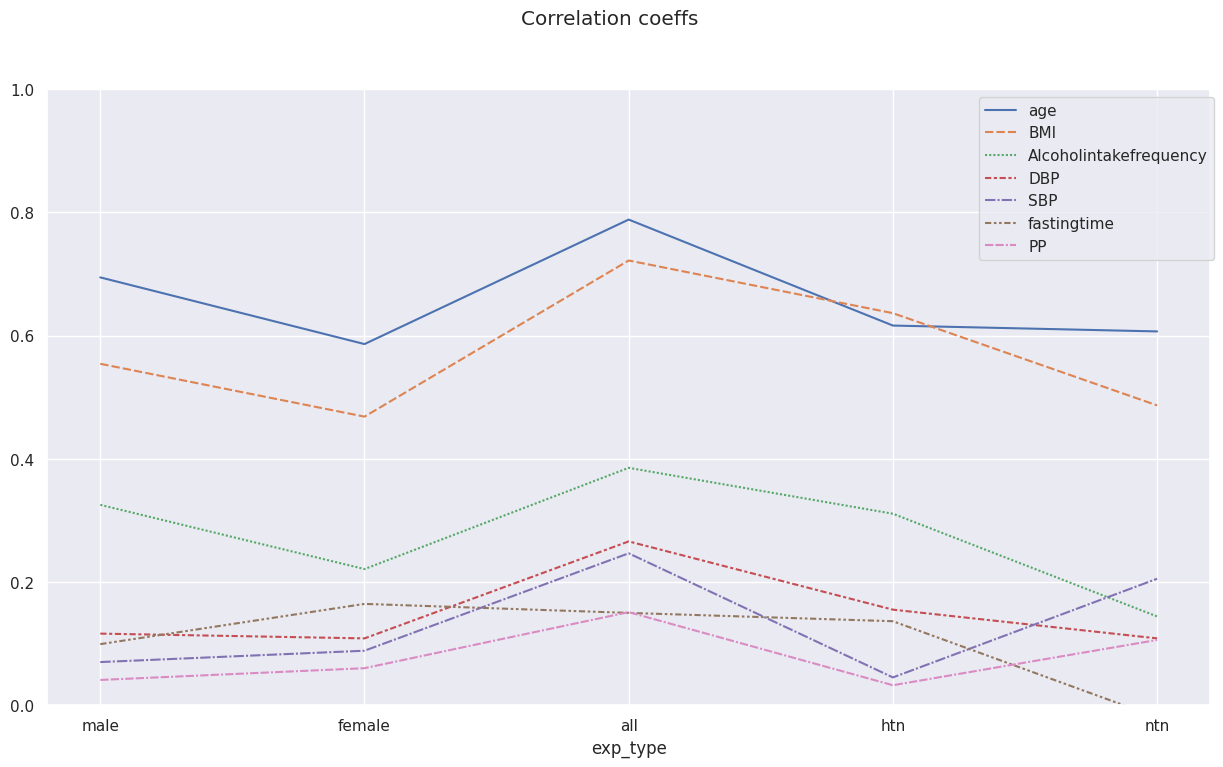

In [44]:
fig, ax = plt.subplots(figsize=(15, 8))
fig.suptitle("Correlation coeffs")
pivot_res = results[["exp_type", "col", "corr"]].pivot_table(index="col", values="corr", columns="exp_type")
pivot_res = pivot_res.reindex(pivot_res.mean(axis=1).sort_values(ascending=False).index)
sns.lineplot(data=pivot_res[["male", "female", "all", "htn", "ntn"]].T)
plt.legend(bbox_to_anchor=(1.01, 1))
ax.set_ylim(0, 1)

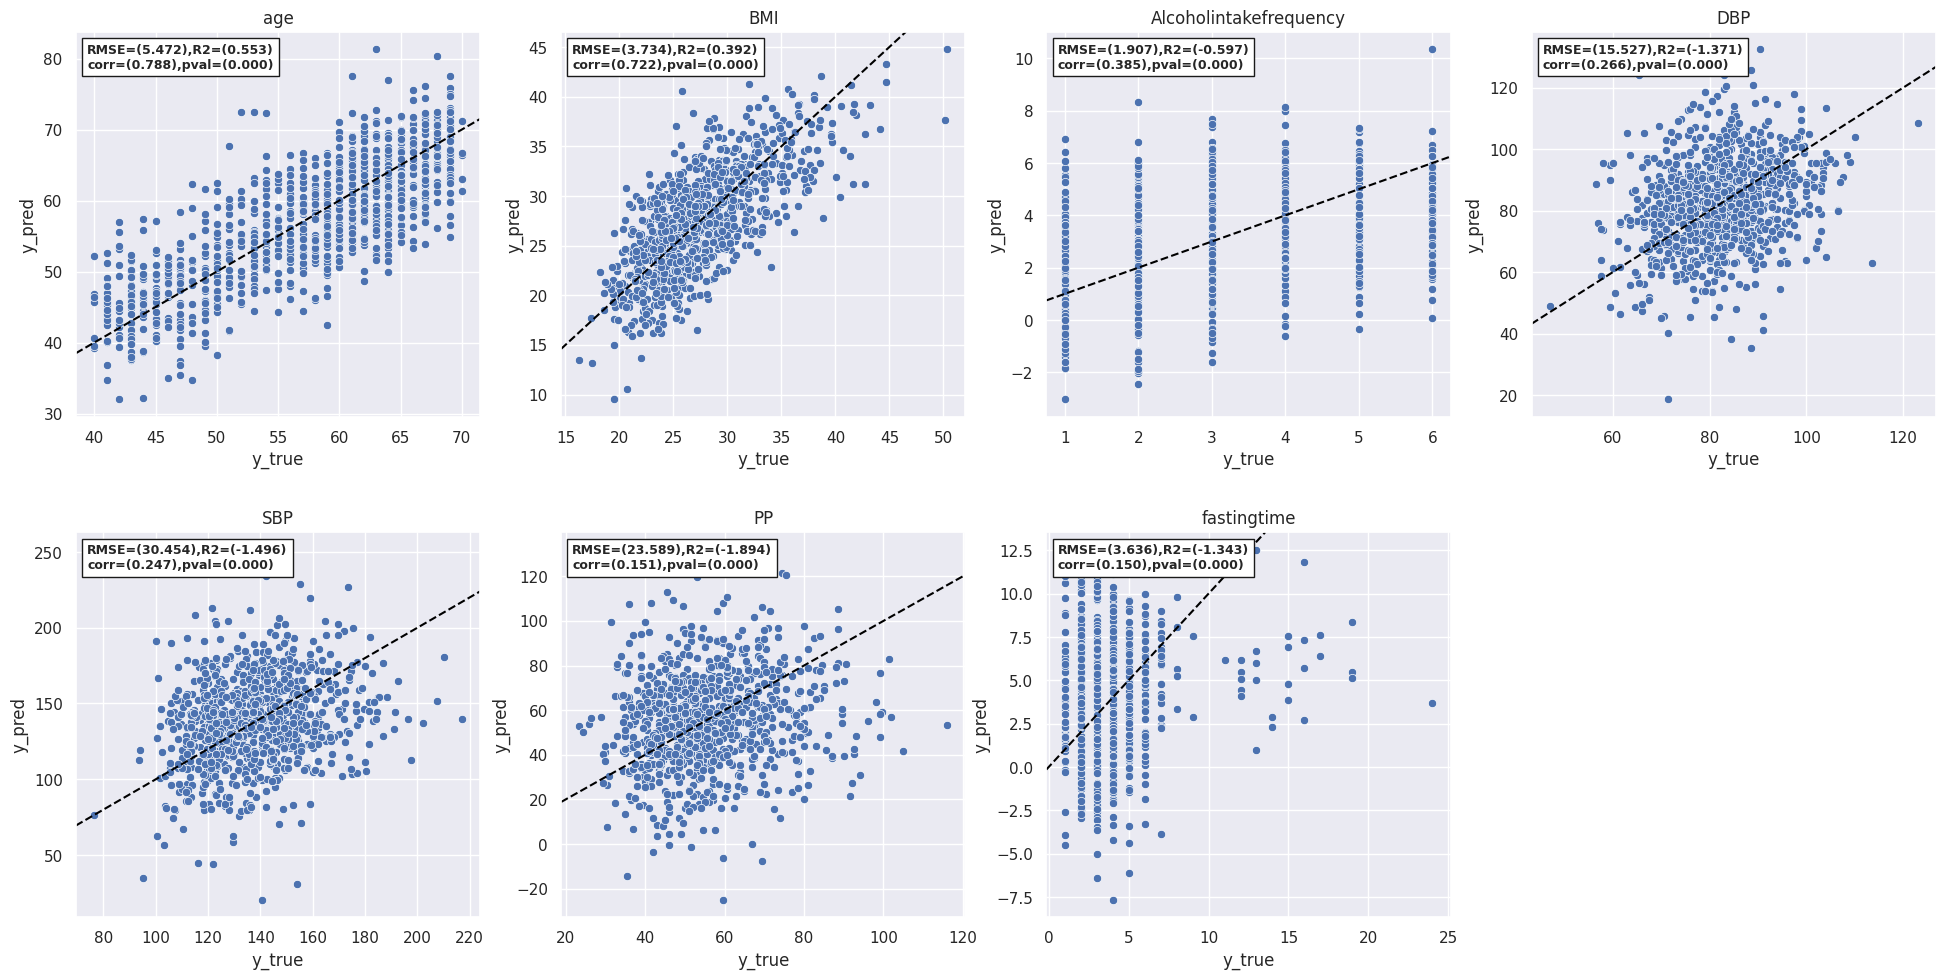

In [38]:
def viz_regressions(reg_results):
    ncol, nrow, s_f = 4, 3, 6
    _, axes = plt.subplots(nrow, ncol, figsize=(ncol * s_f, nrow * s_f), gridspec_kw=dict(hspace=0.3))

    for res, ax in zip_longest(reg_results, axes.flat):
        if res is None:
            ax.remove()
            continue

        sns.scatterplot(x=res["y_true"], y=res["y_pred"], ax=ax)
        ax.set(xlabel="y_true", ylabel=f"y_pred", title=res['col'])

        y_center = np.mean(ax.get_ylim())
        ax.axline((y_center, y_center), slope=1, c="black", ls="--")

        anc = AnchoredText(f"RMSE=({res['rmse']:.3f}),R2=({res['r2']:.3f})\n"
                           f"corr=({res['corr']:.3f}),pval=({res['pval']:.3f})",
                           loc="upper left", frameon=True, prop=dict(size=9, fontweight="bold"))
        ax.add_artist(anc)
        
viz_regressions(reg_all)

### Classification

In [ ]:
def run_classification_exp(ol, cl, n_jobs=6, exp_type=None):
    clas_results = []

    model = LogisticRegression(max_iter=1_000, random_state=SEED)
    reduced_x = PCA(n_components=0.95).fit_transform(ol)
    print(f"Reduced the number of features from {ol.shape[1]} to {reduced_x.shape[1]}")

    for col in tqdm(cl.columns, desc=f"Exp_type: {exp_type}"):
        y_true = cl[col].values
        y_pred = cross_val_predict(model, reduced_x, y_true, cv=5, method="predict_proba", n_jobs=n_jobs)
        y_pred = y_pred[:, 1]

        fpr, tpr, _ = roc_curve(y_true, y_pred)

        clas_results.append({
            "exp_type": exp_type,
            "col": col,
            "bacc": balanced_accuracy_score(y_true, y_pred > 0.5),
            "auc": auc(fpr, tpr),
            "y_pred": y_pred,
            "y_true": y_true,
        })

    clas_results.sort(reverse=True, key=lambda d: d["auc"])

    return clas_results

In [ ]:
clas_all = run_classification_exp(ol_df, vasc_df[cat_cols], exp_type="all")
clas_male = run_classification_exp(ol_df.loc[vasc_df.Sex == 0], vasc_df.loc[vasc_df.Sex == 0][["HTN_on_SBP24"]], exp_type="male")
clas_female = run_classification_exp(ol_df.loc[vasc_df.Sex == 1], vasc_df.loc[vasc_df.Sex == 1][["HTN_on_SBP24"]], exp_type="female")
clas_ntn = run_classification_exp(ol_df.loc[vasc_df.HTN_on_SBP24 == 0], vasc_df.loc[vasc_df.HTN_on_SBP24 == 0][["Sex"]], exp_type="ntn")
clas_htn = run_classification_exp(ol_df.loc[vasc_df.HTN_on_SBP24 == 1], vasc_df.loc[vasc_df.HTN_on_SBP24 == 1][["Sex"]], exp_type="htn")

clas_results = [clas_male, clas_female, clas_all,  clas_ntn, clas_htn]
clas_results = pd.concat([pd.DataFrame.from_dict(res) for res in clas_results], ignore_index=True)

In [ ]:
fig = plt.figure(figsize=(5, 5))
fig.suptitle("Auc coeffs")
ax = sns.lineplot(data=clas_results, x="exp_type", y="auc", hue="col")
ax.set(ylim=(0, 1))
plt.legend(bbox_to_anchor=(1.01, 1));

In [ ]:
def viz_classification(clas_results):
    _, axes = plt.subplots(1, 2, figsize=(10, 5))

    for res, ax in zip_longest(clas_results, axes.flat):
        if res is None:
            ax.remove()
            continue

        fpr, tpr, _ = roc_curve(res["y_true"], res["y_pred"])
        sns.lineplot(fpr, tpr, ax=ax)
        ax.set(xlabel="False-positive rate", ylabel=f"True-positive rate", title=res['col'])

        x_center = np.mean(ax.get_xlim())
        ax.axline((x_center, x_center), slope=1, c="black", ls="--")

        anc = AnchoredText(f"AUC=({res['auc']:.3f}),bacc=({res['bacc']:.2f})",
                           loc="upper left", frameon=True, prop=dict(size=9, fontweight="bold"))
        ax.add_artist(anc)

In [ ]:
viz_classification(clas_all)